In [1]:
from __future__ import division

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

In [7]:
import time

In [2]:
%matplotlib inline

In [3]:
iris = load_iris()
x_iris = iris['data']
y_iris = map(lambda x: np.array([1 if i == x else 0 for i in range(3)]),
        iris['target'])
y_iris = np.array(y_iris)

In [4]:
sigmoid = np.vectorize(lambda x: 1.0/(1.0+np.exp(-x)))
sig = lambda x: 1.0/(1.0+np.exp(-x))
sig_d = lambda x: sig(x) * (1 - sig(x))
sigmoid_d = np.vectorize(lambda x: sig(x) * (1 - sig(x)))

tanh_d = lambda x: 1 - np.square(np.tanh(x))

In [5]:
def log_loss(y, yhat):
    return np.sum(-(y*np.log(yhat) + (1 - y)*np.log(1 - yhat)))

In [203]:
class neural_network:
    
    def __init__(self, sizes, activation = sigmoid, act_d = sigmoid_d):
        '''
        one required arguement: a list with the layer sizes
        can be used for classification or regression
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(x) for x in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.velocity_biases = [np.zeros(x) for x in sizes[1:]]
        self.velocity_weights = [np.zeros((y, x)) for x, y in
                                 zip(sizes[:-1], sizes[1:])]
        
        self.a = [np.zeros(x) for x in sizes]
        self.a_vec = []
        self.activation = activation
        self.act_d = act_d
        self.z = [np.zeros(x) for x in sizes[1:]]
        self.z_vec = []
        
        
    def predict(self,x):
        self.a_vec = []
        self.z_vec = []
        self.a_vec = [x]
        m = x.shape[0]
        biases = [np.matlib.repmat(b, m, 1) for b in self.biases]
        for w, b in zip(self.weights, biases):
            z = np.dot(w, x.T).T + b
            self.z_vec.append(z)
            x = sig(z)
            self.a_vec.append(x)
        
        return x      
                

    def back_prop(self, x, y):
        '''
        vectorized back propigation
        '''
        nabla_w = [None for l in self.weights]
        nabla_b = [None for l in self.weights]
        deltas = [None for l in self.sizes]
        yhat = self.predict(x)
        deltas[-1] = yhat - y
        for l in range(1, self.num_layers - 1)[::-1]:
            w = self.weights[l]
            a = self.a_vec[l]
            z = self.z_vec[l-1]
            deltas[l] = (np.dot(w.T, deltas[l+1].T) * sig_d(z).T).T
        for l in range(0, self.num_layers-1):
            nabla_w[l] =  np.dot(deltas[l+1].T, self.a_vec[l])
            nabla_b[l] = deltas[l+1]
        return nabla_w, [b.sum(axis = 0) for b in nabla_b]
    

                
    def gradient_descent(self, x, y, lr, Lambda, u):
        '''
        vectorized gradient descent function.
        performas a single gradient descent update on the weights and biases
        '''
        m = len(x)
        delta_weights, delta_biases = self.back_prop(x, y)          
        # update velocity values
        self.velocity_weights = [wv * u - wg/m for wg, wv in
                                 zip(delta_weights, self.velocity_weights)]
        self.velocity_biases = [bv * u - bg/m for bg, bv in 
                                zip(delta_biases, self.velocity_biases)]
        # update parameters
        self.weights = [w + lr * (wv + Lambda * w) for
                        wv, w in zip(self.velocity_weights, self.weights)]
        self.biases = [b + lr * bv for bv, b
                        in zip(self.velocity_biases, self.biases)]
        
    
    def fit(self, x, y, batch_size, test_x, test_y,
            learning_rate = 0.01, Lambda = 1e-4,
            velocity_coef = 1, epochs = 1, return_cost = False): 
        '''
        train the neural network using minibatch gradient descent
        '''
        if return_cost:
            cost = []
        for e in xrange(epochs):
#             if e % 4 == 0:
#                 print e
            # create mini batches for minibatch gradient descent
            m = len(x)
            index = np.array(range(m))
            np.random.shuffle(index)
            batch_size = 8
            num_batches = round(m/batch_size,0)
            batches = np.array_split(index, num_batches)
            for batch in batches:
                self.gradient_descent(x[batch], y[batch], learning_rate,
                                      Lambda, velocity_coef)
            if return_cost:
                cost.append(log_loss(test_y, self.predict(test_x)))
        
        if return_cost:
            return cost

In [40]:
t0 = time.time()

my_nn = neural_network([4,8,3])
cost = my_nn.fit(x_iris, y_iris, batch_size = 8,
                 epochs = 10000, return_cost = True)

t1 = time.time()
t1 - t0

16.192999839782715

In [21]:
t0 = time.time()

my_nn = neural_network([4,8,3])
my_nn.fit(x_iris, y_iris, batch_size = 8,
                 epochs = 1000)

t1 = time.time()
t1 - t0

1.4649999141693115

In [19]:
t0 = time.time()
cost = []
my_nn = neural_network([4,8,3])
for j in xrange(1000):
    my_nn.gradient_descent(x_iris, y_iris, 0.01)
    cost.append(log_loss(y_iris, my_nn.predict_vec(x_iris)))
    
t1 = time.time()
t1 - t0

16.092999935150146

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.94      0.97        50
          2       0.94      1.00      0.97        50

avg / total       0.98      0.98      0.98       150



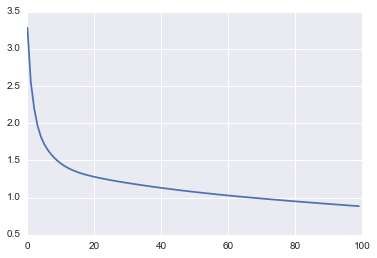

In [208]:
numpy.random.seed(4)
my_nn = neural_network([4, 8, 3])
cost = my_nn.fit(x_iris, y_iris, batch_size = 8,
                 Lambda = 1e-2, learning_rate = 0.01,
                 velocity_coef = 0,
                 epochs = 100, return_cost = True,
                 test_x = x_iris, test_y = y_iris)


plt.plot(np.array(cost)/len(x_iris))
yhat = my_nn.predict(x_iris)
yhat_vec = np.argmax(yhat, axis = 1)
print classification_report(np.argmax(y_iris, axis = 1), yhat_vec)

In [8]:
import pandas as pd

In [9]:
minst_df = pd.read_csv('C:/Users/jay.swinney/Desktop/minst.csv')
minst = minst_df.values[:,1:]
minst_lables = minst_df['label']

In [10]:
from sklearn.cross_validation import train_test_split

In [38]:
from sklearn.metrics import confusion_matrix

In [30]:
from sklearn.metrics import classification_report

In [11]:
minst_train, minst_test, label_train, label_test = train_test_split(
    minst, minst_lables, test_size = 0.2)

In [50]:
minst.shape

(42000L, 784L)

In [12]:
def expand_y(y):
    out = np.zeros(10)
    out[y] = 1
    return out

# expand = np.vectorize(expand_y)

In [13]:
label_test = np.array(map(expand_y,label_test))
label_train = np.array(map(expand_y,label_train))

In [191]:
t0 = time.time()

my_nn = neural_network([784,784/2, 10])
cost = my_nn.fit(minst_train, label_train, batch_size = 100,
                 Lambda = 1e-4, learning_rate = 0.01,
                 epochs = 25, return_cost = True,
                 velocity_coef = 0.3,
                 test_x = minst_test[0:1000],
                 test_y = label_test[0:1000])

t1 = time.time()
t1 - t0

0
4
8
12
16
20
24


1146.9739999771118

[[790   0   2   3   2  14   5   1  13]
 [  0 929   2   6   2   3   1   1   5]
 [  7  10 759  24   7   8  22  12  17]
 [  1   7  22 758   3  58   7   8  34]
 [  2   2   3   2 681  15  13   3   8]
 [  9   2   7  27   6 654   9   4  17]
 [ 11   3   5   1  12  29 732   1   6]
 [  7  11   7   7  11   8   1 779   8]
 [  3   9  14  30   7  46   7   8 674]]
             precision    recall  f1-score   support

          0       0.94      0.95      0.95       830
          1       0.95      0.98      0.96       950
          2       0.92      0.87      0.89       872
          3       0.87      0.84      0.85       905
          4       0.85      0.88      0.87       771
          5       0.77      0.88      0.82       740
          6       0.91      0.92      0.91       800
          7       0.90      0.90      0.90       863
          8       0.83      0.84      0.84       804
          9       0.88      0.78      0.83       865

avg / total       0.89      0.88      0.88      8400



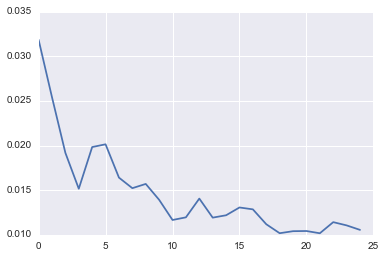

In [192]:
yhat = my_nn.predict(minst_test)
yhat_vec = np.argmax(yhat, axis = 1)
print confusion_matrix(np.argmax(label_test, axis = 1),
                       yhat_vec, labels = range(9))

print classification_report(np.argmax(label_test, axis = 1),
                            yhat_vec)
plt.plot(np.array(cost)/len(label_test))